# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

In [ ]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pwd
!ls

In [ ]:
import os
os.chdir("/content/drive/My Drive/Untrained-PINN-for-SIM-main")
print(os.getcwd())

In [ ]:
import cv2#show first picture of folder as image in notebook
img = cv2.imread('Data/LPSIM/microtubules/input_frames/1_1.png')
plt.imshow(img)

## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


In [ ]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('your_dataset.csv')

# Feature selection
# Example: Selecting only two features for a simple baseline model
X = df[['feature1', 'feature2']]
y = df['target_variable']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Implementation

[Implement your baseline model here.]



In [1]:
# Initialize and train the baseline model
# Example for a classification problem using Logistic Regression
# model = LogisticRegression()
# model.fit(X_train, y_train)

# Your implementation code here


In [2]:
import numpy as np
import cv2

num_im = 50      # Number of examples in dataset
frames = 24       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
bg_lvl = 0       # Optional bg level subtraction

input_frames = np.zeros([num_im,im_dim,im_dim,frames])
gt_frames = np.zeros([num_im,im_dim,im_dim,1])
lr_frames = np.zeros([num_im,im_dim,im_dim,1])
patterns = np.zeros([frames,im_dim,im_dim,1])


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## 2. Load Data

In [ ]:
data_name = 'microtubules'
dir_name = 'Data/LPSIM/'

for i in range(1,num_im):
      
    for j in range(1,(frames+1)):
       
        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_frames[i-1,:,:,j-1] = input_temp                  
    
    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_frames[i-1,:,:,:] = lr_temp
    

for i in range(1,(frames+1)):
    
    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)  
    pattern = pattern.reshape([im_dim,im_dim,1])
    patterns[i-1,:,:,:] = pattern
            

## 3. Check and Normalize Data

In [ ]:
print(np.amax(input_frames))
input_frames = input_frames - bg_lvl;
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
print(np.amax(input_frames))
gt_fames = gt_frames/np.amax(gt_frames)
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)
print(input_frames.shape)
print(gt_frames.shape)

255.0
1.0
(50, 480, 480, 24)
(50, 480, 480, 1)


Text(0.5, 1.0, 'Illumination pattern')

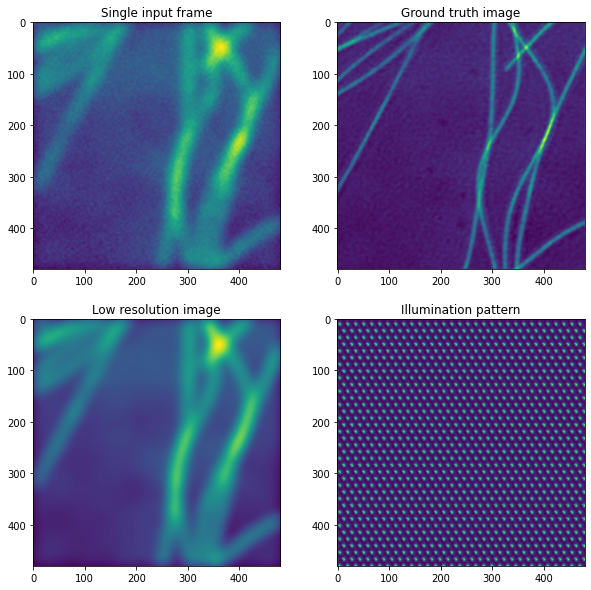

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(input_frames[1,:,:,1])
plt.title('Single input frame')
plt.subplot(2,2,2)
plt.imshow(gt_frames[1,:,:,:])
plt.title('Ground truth image')
plt.subplot(2,2,3)
plt.imshow(lr_frames[1,:,:,:])
plt.title('Low resolution image')
plt.subplot(2,2,4)
plt.imshow(patterns[1,:,:,:])
plt.title('Illumination pattern')

## 4. Define PSF

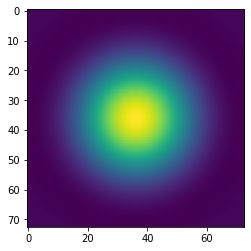

In [ ]:
psf = cv2.imread(dir_name+data_name+'/psf.png',0)
plt.imshow(psf)
psf = np.reshape(psf,[np.ma.size(psf,0),np.ma.size(psf,0),1,1])

## Define Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

def baseline_model():
    # Input layer with shape (im_dim, im_dim, 1) for low-resolution images
    inputs = Input(shape=(im_dim, im_dim, 1))

    # Encoder part / feature extraction layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# No upsampling layers were added for simplicity reasons

    # Decoder part / reconstruction layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer: 1 filter for a single channel output image
    # Using 'relu' to keep pixel values non-negative and capped at 1.0 due to previous normalization
    outputs = Conv2D(1, (3, 3), activation='relu', padding='same')(x)


    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the baseline model
baseline_cnn_model = baseline_model()

# Print the model summary
print("Baseline CNN Model Architecture:")
baseline_cnn_model.summary()


In [ ]:
# Define the loss function and optimizer
opt_baseline = tf.keras.optimizers.Adam(lr_schedule)

# Compile and train the baseline model

mse_loss = tf.keras.losses.MeanSquaredError()

eps = 1000

baseline_cnn_model.compile(loss=mse_loss, optimizer=opt_baseline)
baseline_model_history = baseline_cnn_model.fit(x=x_baseline, y=y_baseline, epochs=eps, batch_size=batch_size)

print("Baseline CNN model compiled and trained.")
print(f"Final training loss (MSE): {baseline_model_history.history['loss'][-1]}")

In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, eps, num=eps), baseline_model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Baseline Model Optimization Loss (MSE)')
plt.show()

In [ ]:
#Compile the model

learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50,
    decay_rate=0.90,
    staircase=True)

opt_supervised = tf.keras.optimizers.Adam(lr_schedule)
batch_size = 1


supervised_model.compile(loss=mse_loss, optimizer=opt_supervised)
supervised_model_history = supervised_model.fit(x=x_supervised, y=y_supervised, epochs=eps, batch_size=batch_size)

print("Supervised model compiled and trained.")
print(f"Final training loss (MSE): {supervised_model_history.history['loss'][-1]}")

In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, eps, num=eps), supervised_model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Supervised Model Optimization Loss (MSE)')
plt.show()

In [ ]:
#compare results

predicted_supervised = supervised_model.predict(x_supervised)

# Reshape and normalize the predicted image
predicted_supervised = predicted_supervised.reshape([im_dim, im_dim])
predicted_supervised = predicted_supervised[20:(im_dim-20), 20:(im_dim-20)]
predicted_supervised = (predicted_supervised - np.amin(predicted_supervised)) / (np.amax(predicted_supervised) - np.amin(predicted_supervised))

# Prepare ground truth (y_supervised) for visualization
gt_supervised_viz = y_supervised.reshape([im_dim, im_dim])
gt_supervised_viz = gt_supervised_viz[20:(im_dim-20), 20:(im_dim-20)]
gt_supervised_viz = (gt_supervised_viz - np.amin(gt_supervised_viz)) / (np.amax(gt_supervised_viz) - np.amin(gt_supervised_viz))

# Prepare low-resolution input (x_supervised) for visualization
lr_supervised_viz = x_supervised.reshape([im_dim, im_dim])
lr_supervised_viz = lr_supervised_viz[20:(im_dim-20), 20:(im_dim-20)]
lr_supervised_viz = (lr_supervised_viz - np.amin(lr_supervised_viz)) / (np.amax(lr_supervised_viz) - np.amin(lr_supervised_viz))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(gt_supervised_viz, cmap='inferno')
plt.title('Ground Truth Image')
plt.subplot(1,3,2)
plt.imshow(predicted_supervised, cmap='inferno')
plt.title('Supervised Model Result')
plt.subplot(1,3,3)
plt.imshow(lr_supervised_viz, cmap='inferno')
plt.title('Low Resolution Input')
plt.show()

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [ ]:
# Evaluate the baseline model
# Example for a classification problem
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# For a regression problem, you might use:
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here
